In [1]:
from netpred.analysis import *
import seaborn as sns


def normalise_rows(a):
    return a / a.sum(1)[:, None]

2022-04-09 17:19:27 Decompressing full_protein_dssp_annotations.json.gz
2022-04-09 17:19:27 Decompressing single_domain_dssp_annotations.json.gz
2022-04-09 17:19:34 Parsing casp11/validation...


NetPred(
  (prediction): PredictionNetwork(
    (stack): Sequential(
      (0): Linear(in_features=594, out_features=243, bias=True)
      (1): ReLU()
      (2): Linear(in_features=243, out_features=81, bias=True)
    )
  )
  (relu): ReLU()
  (filtering): FilteringNetwork(
    (stack): Sequential(
      (0): Linear(in_features=81, out_features=81, bias=True)
      (1): ReLU()
      (2): Linear(in_features=81, out_features=3, bias=True)
    )
  )
)


2022-04-09 17:19:34 Loaded 223 sequences from casp11/validation.
2022-04-09 17:19:34 Creating windows for casp11/validation ...
2022-04-09 17:19:35 Windowing complete for casp11/validation (created 48979 windows).


In [2]:
# plot centre amino acid against prediction frequency (20x3)

predictions_by_centre_aa = np.zeros((len(amino_names), 3))
actual_by_centre_aa = np.zeros((len(amino_names), 3))

for window, target in test_set:
    centre_aa = window[:-2, WINDOW_CENTRE].argmax().item()
    prediction = net(window.reshape(1, WINDOW_SIZE * PSSM_ROWS)).argmax().item()
    predictions_by_centre_aa[centre_aa][prediction] += 1
    actual_by_centre_aa[centre_aa][target] += 1
       
predictions_by_centre_aa = normalise_rows(predictions_by_centre_aa).T
actual_by_centre_aa = normalise_rows(actual_by_centre_aa).T

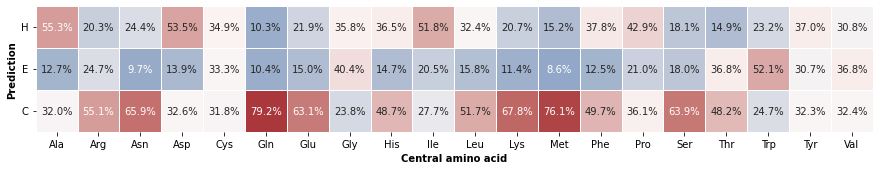

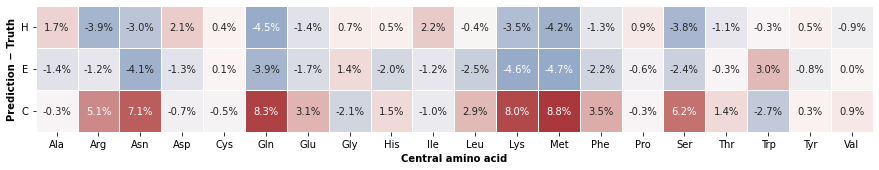

In [3]:
def plot_classifier_frequency_for_aa(data, centre, ylabel):
    plt.figure(figsize=(15,3))
    p = sns.heatmap(data,
                     cmap='vlag',
                     square=True,
                     xticklabels=sorted(amino_names),
                     yticklabels=ENCODE_3_STATE,
                     annot=True,
                     fmt='.1%',
                     cbar=False,
                     center=centre,
                     linewidth=1)
    p.set_xlabel('Central amino acid', weight='bold')
    p.set_ylabel(ylabel, weight='bold')
    plt.yticks(rotation=0)

plot_classifier_frequency_for_aa(predictions_by_centre_aa, centre=1/3, ylabel='Prediction')
plt.savefig('prediction_vs_central.pdf')
plot_classifier_frequency_for_aa(predictions_by_centre_aa - actual_by_centre_aa, 0, 'Prediction − Truth')
plt.savefig('prediction_minus_truth_vs_central.pdf')

In [4]:
# test pure alanine oligo
ala = torch.zeros((1, PSSM_ROWS, WINDOW_SIZE))
ala[:, 19] += 1
# plot_pssm(ala, output, test_target)
print(net(ala))

# sd = ig.attribute(inputs=ala, target=0)
# sd = sd.detach().view(21, 15).numpy()
# plot_pssm(sd, output, test_target)

tensor([[ 8.4433, -8.8192,  0.8506]])


In [5]:
############################################# 3/2/22
# My hypothesis is that the network only looks at amino acid frequency, not patterns
# And further that this is not the best way for it to work

# If simple frequency across the window is all that is looked at, then randomising the order of the AAs should not decrease prediction frequency much.
# But I doubt it's as simple as that; I think that the middle AA is usually much more important than anything else
# I think this because
#    a) the integrated gradient usually shows this pattern of activation and
#    b) looking at the central AA is highly predictive of the state for some AAs

# So we can test the accuracy with a scrambled window...
# ... the accuracy is 52%
#

In [6]:
# window scrambling

def scramble_window(t, retain: int):
    """Shuffle a window, keeping `retain` middle columns same."""
    if retain == 0:  # complete scramble
        return t[:, torch.randperm(WINDOW_SIZE)]
    
    assert retain % 2 == 1, 'retain must be odd or zero'
    
    keep_len = retain // 2
    start, end = WINDOW_CENTRE - keep_len, WINDOW_CENTRE + keep_len
    to_keep = torch.arange(start, end+1)
    indices = torch.arange(WINDOW_SIZE)
    to_shuffle = torch.cat([indices[:start], indices[end+1:]]).numpy()
    np.random.shuffle(to_shuffle)
    first, last = torch.tensor(to_shuffle).chunk(2)
    shuffled_indices = torch.cat([first, to_keep, last])
    return t[:, shuffled_indices]

accuracy = lambda t: (t[0] / t[1]).item()

results_retain_q3 = {}

for r in [0, *range(1, WINDOW_SIZE, 2), WINDOW_SIZE]:
    scrambled_results = torch.zeros(2)  # [correct count, total count]
    for window, target in test_set:
        window = scramble_window(window, retain=r)
        prediction = net(window.reshape(1, WINDOW_SIZE * PSSM_ROWS)).argmax().item()
        scrambled_results += np.array([int(prediction == target), 1])
    results_retain_q3[r] = accuracy(scrambled_results) * 100

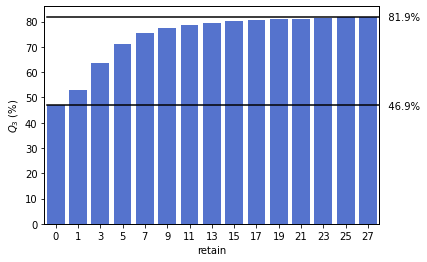

In [7]:
# plotting for window scrambling

ax = sns.barplot(x=list(results_retain_q3.keys()), y=list(results_retain_q3.values()), color='royalblue')
ax.set(xlabel='retain', ylabel='$Q_3$ (%)')

max_score = max(results_retain_q3.values())
min_score = min(results_retain_q3.values())

ax.annotate(text=f'   {max_score:.1f}%', xy=(14.5, max_score - 1.5))
ax.annotate(text=f'   {min_score:.1f}%', xy=(14.5, min_score - 1.5))

ax2 = ax.twinx()
ax2.set_ylim(ax.get_ylim())
ax2.set_xlim(ax.get_xlim())
ax2.axes.yaxis.set_visible(False)
sns.lineplot(x=[-0.39, 15], y=[min_score] * 2, color='black', ax=ax2)

ax3 = ax.twinx()
ax3.set_ylim(ax.get_ylim())
ax3.set_xlim(ax.get_xlim())
ax3.axes.yaxis.set_visible(False)
sns.lineplot(x=[-0.39, 15], y=[max_score] * 2, color='black', ax=ax3)
plt.savefig('retain.pdf')

In [8]:
from itertools import groupby

predictions = []
targets = []
for window, target in test_set:
    prediction = net(window.reshape(1, WINDOW_SIZE * PSSM_ROWS)).argmax().item()
    predictions.append(prediction)
    targets.append(target)

Total helices 1703
Threes 310
1 + 2s 0
Median 8.0


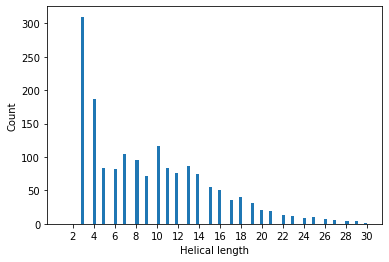

Total helices 2107
Threes 149
1 + 2s 711
Median 6.0


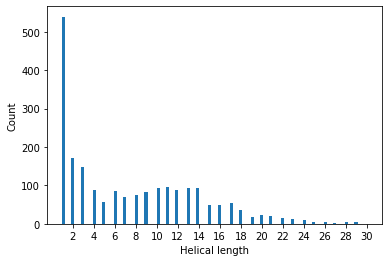

In [9]:
# plot histogram of helix lengths

for set_ in [targets, predictions]:
    lengths = []
    for alpha, group in groupby(set_, key=lambda p: p == 0):
        if alpha:
            lengths.append(len(list(group)))

    print('Total helices', len(lengths))
    print('Threes', lengths.count(3))
    print('1 + 2s', lengths.count(1) + lengths.count(2))
    print('Median', np.median(lengths))

    plt.hist(lengths, 100, range=[1, 30])  # [2, 24]
    plt.xticks(range(2, 32, 2), np.arange(2, 32, 2))
    plt.xlabel('Helical length')
    plt.ylabel('Count')
    plt.savefig(f'{"targets" if set_ is targets else "predictions"}_helix_lengths.pdf')
    plt.show()